# Pré-processamento - Parte 2

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import gower
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

plt.rcParams["figure.figsize"] = (21,9)
plt.rcParams['font.size'] = 20

In [43]:
# Função para plotar um gráfico
def plotar_grafico(coluna, titulo):
    print(df[coluna].value_counts(), df[coluna].unique())
    df.groupby([coluna, 'Q002']).size().groupby(level=0).apply(
        lambda x: 100 * x / x.sum()
    ).unstack().plot(kind='bar',stacked=True)
    plt.rcParams["figure.figsize"] = (30,10)
    plt.title(titulo)
    plt.xlabel("")
    plt.show()

In [44]:
#plotar_grafico('C008', 'Hipertensão por idade')

In [45]:
#plotar_grafico('P02601', 'Hipertensão por Considerando a comida preparada na hora e os alimentos industrializados, o(a) sr(a) acha que seu consumo de sal é:')

In [46]:
# Função para normalizar uma coluna entre 0 e 1
def normalizar(coluna):
    minimo, maximo = coluna.min(), coluna.max()
    normalizada = coluna.to_numpy()
    normalizada = (normalizada - minimo) / (maximo - minimo)
    return normalizada

In [47]:
#Variáveis e suas explicações
variaveis = [
    ('V0001', 'Hipertensão por estado brasileiro'),
    ('C008', 'Hipertensão por idade'),
    ('C009', 'Hipertensão por Cor ou raça'),
    ('C010', 'Hipertensão por vive com cônjuge ou companheiro (a)?'),
    ('E001', 'Hipertensão por trabalhou ou estagiou, durante pelo menos uma hora, em alguma atividade remunerada em dinheiro?'),
    ('E003', 'Hipertensão por fez algum bico ou trabalhou em alguma atividade ocasional remunerada durante pelo menos 1 hora?'),
    ('J001', 'Hipertensão por De um modo geral, como é o estado de saúde de?'),
    ('M016', 'Hipertensão por Nos últimos 12 meses, com que frequência o(a) sr(a) participou de atividades esportivas ou artísticas em grupo?'),
    ('N010', 'Hipertensão por Nas duas últimas semanas, com que frequência o(a) sr(a) teve problemas no sono, como dificuldade para adormecer, acordar frequentemente à noite ou dormir mais do que de costume?'),
    ('N011', 'Hipertensão por Nas duas últimas semanas, com que frequência o(a) sr(a) teve problemas por não se sentir descansado(a) e disposto(a) durante o dia, sentindo-se cansado(a), sem ter energia?'),
    ('N012', 'Hipertensão por Nas duas últimas semanas, com que frequência o(a) sr(a) teve pouco interesse ou não sentiu prazer em fazer as coisas?'),
    ('N013', 'Hipertensão por Nas duas últimas semanas, com que frequência o(a) sr(a) teve problemas para se concentrar nas suas atividades habituais?'),
    ('N014', 'Hipertensão por Nas duas últimas semanas, com que frequência o(a) sr(a) teve problemas na alimentação, como ter falta de apetite ou comer muito mais do que costume?'),
    ('N015', 'Hipertensão por Nas duas últimas semanas, com que frequência o(a) sr(a) teve lentidão para se movimentar ou falar, ou ao contrário, ficou muito agitado(a) ou inquieto(a)?'),
    ('N016', 'Hipertensão por Nas duas últimas semanas, com que frequência o(a) sr(a) se sentiu deprimido(a), “pra baixo” ou sem perspectiva?'),
    ('N017', 'Hipertensão por Nas duas últimas semanas, com que frequência o(a) sr(a) se sentiu mal consigo mesmo, se achando um fracasso ou achando que decepcionou sua família?'),
    ('P006', 'Hipertensão por Em quantos dias da semana o(a) sr(a) costuma comer feijão?'),
    ('P007', 'Hipertensão por Em quantos dias da semana, o(a) sr(a) costuma comer salada de alface e tomate ou salada de qualquer outra verdura ou legume cru?'),
    ('P009', 'Hipertensão por Em quantos dias da semana, o(a) sr(a) costuma comer verdura ou legume cozido, como couve, cenoura, chuchu, berinjela, abobrinha?'),
    ('P011', 'Hipertensão por Em quantos dias da semana o(a) sr(a) costuma comer carne vermelha (boi, porco, cabrito)?'),
    ('P013', 'Hipertensão por Em quantos dias da semana o(a) sr(a) costuma comer frango/galinha?'),
    ('P015', 'Hipertensão por Em quantos dias da semana o(a) sr(a) costuma comer peixe?'),
    ('P016', 'Hipertensão por Em quantos dias da semana o(a) sr(a) costuma tomar suco de frutas natural?'),
    ('P018', 'Hipertensão por Em quantos dias da semana o(a) sr(a) costuma comer frutas?'),
    ('P020', 'Hipertensão por Em quantos dias da semana o(a) sr(a) costuma tomar refrigerante ou suco artificial?'),
    ('P023', 'Hipertensão por Em quantos dias da semana o(a) sr(a) costuma tomar leite?'),
    ('P025', 'Hipertensão por Em quantos dias da semana o(a) sr(a) come alimentos doces, tais como pedaços de bolo ou torta, doces, chocolates, balas, biscoitos ou bolachas doces?'),
    ('P026', 'Hipertensão por Em quantos dias da semana o(a) sr(a) substitui a refeição do almoço ou jantar por sanduiches, salgados ou pizzas?'),
    ('P02601', 'Hipertensão por Considerando a comida preparada na hora e os alimentos industrializados, o(a) sr(a) acha que seu consumo de sal é:'),
    ('P034', 'Hipertensão por Nos últimos três meses, o(a) sr(a) praticou algum tipo de exercício físico ou esporte?'),
    ('P042', 'Hipertensão por Nas suas atividades habituais (tais como ir a algum curso, escola ou clube ou levar alguém a algum curso, escola ou clube), quantos dias por semana o(a) sr(a) faz alguma atividade que envolva deslocamento a pé ou bicicleta?'),
    ('P044', 'Hipertensão por Nas suas atividades domésticas, o(a) sr(a) faz faxina pesada, carrega peso ou faz outra atividade pesada que requer esforço físico intenso?'),
    ('P045', 'Hipertensão por Em média, quantas horas por dia o(a) sr(a) costuma ficar assistindo televisão?'),
    ('P050', 'Hipertensão por Atualmente, o(a) sr(a) fuma algum produto do tabaco?'),
    ('P068', 'Hipertensão por Com que frequência alguém fuma dentro do seu domicílio?'),
    ('Q002', 'Hipertensão'),
    ('X001', 'Hipertensão por Quando foi a última vez que o(a) sr(a) consultou um médico?'),
    ('regiao', 'Hipertensão por região do Brasil')
]

In [48]:
df = pd.read_csv('hipertensao_18a25.csv', sep=';')
df.head()

,V0001,C008,C009,C010,E001,E003,J001,M016,N010,N011,...,P026,P02601,P034,P042,P044,P045,P050,P068,Q002,X001
0,11,23,4,1.0,2.0,2.0,3,6.0,1.0,2.0,...,2,4.0,2.0,0,2.0,5.0,3.0,5.0,1.0,2.0
1,11,24,4,1.0,2.0,2.0,3,6.0,1.0,1.0,...,7,4.0,2.0,5,2.0,5.0,3.0,4.0,1.0,3.0
2,11,19,4,2.0,2.0,2.0,3,6.0,1.0,1.0,...,0,4.0,2.0,7,2.0,5.0,3.0,5.0,1.0,2.0
3,11,21,4,1.0,1.0,2.0,2,6.0,1.0,1.0,...,2,3.0,2.0,0,2.0,2.0,3.0,5.0,1.0,5.0
4,11,24,4,1.0,2.0,2.0,3,6.0,1.0,1.0,...,0,3.0,2.0,3,2.0,5.0,3.0,5.0,1.0,5.0


# Verificando outliers com matriz de similaridades de Gower

In [49]:
matriz_similaridades = gower.gower_matrix(df)
# fazer o corte em 0.65 e verificar quais desses do corte teve mais ocorrências de dissimilaridade acima do corte

In [50]:
matriz_similaridades

array([[0.        , 0.2001287 , 0.24581724, ..., 0.4092664 , 0.41087517,
        0.3030888 ],
       [0.2001287 , 0.        , 0.3018018 , ..., 0.47232947, 0.4662162 ,
        0.33783785],
       [0.24581724, 0.3018018 , 0.        , ..., 0.48262548, 0.60778636,
        0.4124839 ],
       ...,
       [0.4092664 , 0.47232947, 0.48262548, ..., 0.        , 0.32078508,
        0.24259974],
       [0.41087517, 0.4662162 , 0.60778636, ..., 0.32078508, 0.        ,
        0.3246461 ],
       [0.3030888 , 0.33783785, 0.4124839 , ..., 0.24259974, 0.3246461 ,
        0.        ]], dtype=float32)

In [51]:
similaridades = matriz_similaridades.flatten()
similaridades.sort()

In [52]:
serie = pd.Series(similaridades)
serie.describe()

count    5.817744e+06
mean     2.962051e-01
std      7.326698e-02
min      0.000000e+00
25%      2.409910e-01
50%      2.873230e-01
75%      3.388031e-01
max      6.892536e-01
dtype: float64

In [53]:
serie.drop_duplicates(inplace=True)
serie

0          0.000000
2414       0.042471
2416       0.043436
2418       0.048263
2420       0.048584
             ...   
5817734    0.674260
5817736    0.677027
5817738    0.677606
5817740    0.686293
5817742    0.689254
Length: 8881, dtype: float32

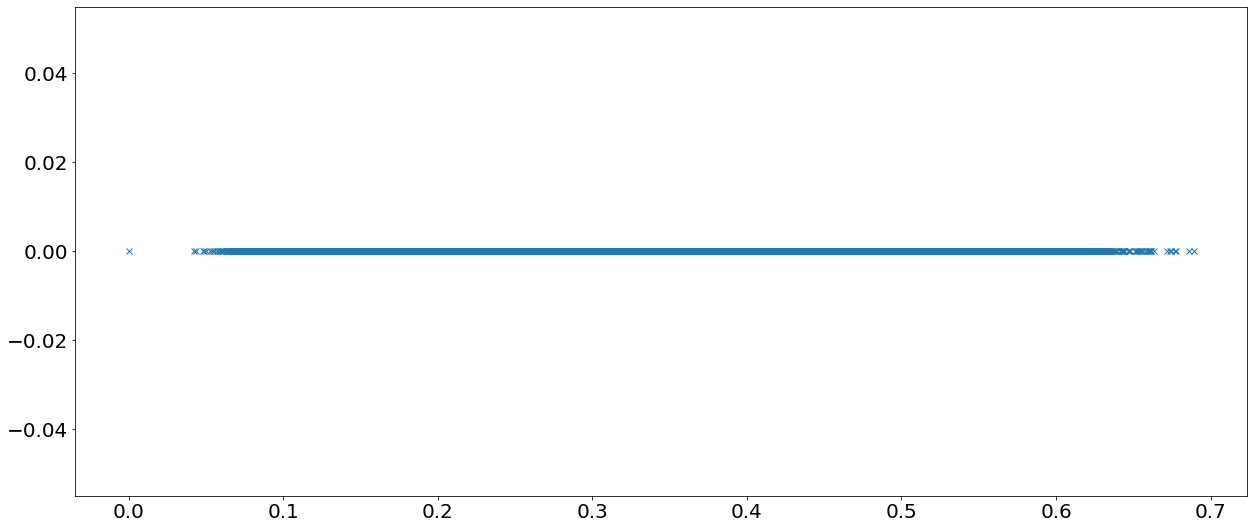

In [54]:
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(serie, np.zeros_like(serie) + val, 'x')
plt.show()

In [55]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2412 entries, 0 to 2411
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V0001   2412 non-null   int64  
 1   C008    2412 non-null   int64  
 2   C009    2412 non-null   int64  
 3   C010    2412 non-null   float64
 4   E001    2412 non-null   float64
 5   E003    2412 non-null   float64
 6   J001    2412 non-null   int64  
 7   M016    2412 non-null   float64
 8   N010    2412 non-null   float64
 9   N011    2412 non-null   float64
 10  N012    2412 non-null   float64
 11  N013    2412 non-null   float64
 12  N014    2412 non-null   float64
 13  N015    2412 non-null   float64
 14  N016    2412 non-null   float64
 15  N017    2412 non-null   float64
 16  P006    2412 non-null   int64  
 17  P007    2412 non-null   int64  
 18  P009    2412 non-null   int64  
 19  P011    2412 non-null   int64  
 20  P013    2412 non-null   int64  
 21  P015    2412 non-null   int64  
 22  

In [56]:
# V001 -> estados -> passando para regiões do brasil

testeRegioes = df

regiao = testeRegioes['V0001'].copy()

for i in range(testeRegioes.shape[0]):
    regiao.iloc[i] = regiao.iloc[i] // 10

testeRegioes['regiao'] = regiao

testeRegioes['regiao'].value_counts()

2    731
1    625
3    487
5    324
4    245
Name: regiao, dtype: int64

In [57]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2412 entries, 0 to 2411
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V0001   2412 non-null   int64  
 1   C008    2412 non-null   int64  
 2   C009    2412 non-null   int64  
 3   C010    2412 non-null   float64
 4   E001    2412 non-null   float64
 5   E003    2412 non-null   float64
 6   J001    2412 non-null   int64  
 7   M016    2412 non-null   float64
 8   N010    2412 non-null   float64
 9   N011    2412 non-null   float64
 10  N012    2412 non-null   float64
 11  N013    2412 non-null   float64
 12  N014    2412 non-null   float64
 13  N015    2412 non-null   float64
 14  N016    2412 non-null   float64
 15  N017    2412 non-null   float64
 16  P006    2412 non-null   int64  
 17  P007    2412 non-null   int64  
 18  P009    2412 non-null   int64  
 19  P011    2412 non-null   int64  
 20  P013    2412 non-null   int64  
 21  P015    2412 non-null   int64  
 22  

In [58]:
#for item in variaveis:
#    plotar_grafico(item[0], item[1])

In [59]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2412 entries, 0 to 2411
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V0001   2412 non-null   int64  
 1   C008    2412 non-null   int64  
 2   C009    2412 non-null   int64  
 3   C010    2412 non-null   float64
 4   E001    2412 non-null   float64
 5   E003    2412 non-null   float64
 6   J001    2412 non-null   int64  
 7   M016    2412 non-null   float64
 8   N010    2412 non-null   float64
 9   N011    2412 non-null   float64
 10  N012    2412 non-null   float64
 11  N013    2412 non-null   float64
 12  N014    2412 non-null   float64
 13  N015    2412 non-null   float64
 14  N016    2412 non-null   float64
 15  N017    2412 non-null   float64
 16  P006    2412 non-null   int64  
 17  P007    2412 non-null   int64  
 18  P009    2412 non-null   int64  
 19  P011    2412 non-null   int64  
 20  P013    2412 non-null   int64  
 21  P015    2412 non-null   int64  
 22  

# Trabalhando com cada variável

In [60]:
# Retirando variáveis

# V0001 -> representa estados, agregamos em regiões no atributo regiao
# J001 -> percepção do estado de saúde entra mais como consequência do que como causa da hipertensão
lista = ['V0001', 'J001']
df.drop(columns=lista, inplace= True)

In [61]:
df.to_csv("hipertensao_preprocessada.csv",sep=';', index=False)

In [62]:
# C009 - criando uma variável para cada resposta (não sei uma função pronta numa biblioteca, fiz na mão)
branco = df[df['C009'] == 1]['C009']
preto = df[df['C009'] == 2]['C009'].copy()
preto.loc[preto != 0] = 1
amarelo = df[df['C009'] == 3]['C009'].copy()
amarelo.loc[amarelo != 0] = 1
pardo = df[df['C009'] == 4]['C009'].copy()
pardo.loc[pardo != 0] = 1
indigena = df[df['C009'] == 5]['C009'].copy()
indigena.loc[indigena != 0] = 1

df['C009_branco'] = branco
df['C009_branco'].fillna(value=0, inplace=True)
df['C009_preto'] = preto
df['C009_preto'].fillna(value=0, inplace=True)
df['C009_amarelo'] = amarelo
df['C009_amarelo'].fillna(value=0, inplace=True)
df['C009_pardo'] = pardo
df['C009_pardo'].fillna(value=0, inplace=True)
df['C009_indigena'] = indigena
df['C009_indigena'].fillna(value=0, inplace=True)

#df.info(verbose=True, null_counts=True)
#print(df['C009'].value_counts())
#print(df['C009_branco'].value_counts())
#print(df['C009_preto'].value_counts())
#print(df['C009_amarelo'].value_counts())
#print(df['C009_pardo'].value_counts())
#print(df['C009_indigena'].value_counts())
#df.sample(10)
df.drop(columns=['C009'], inplace=True)

In [63]:
# regiao - criando uma variável para cada resposta (não sei uma função pronta numa biblioteca, fiz na mão)
norte = df[df['regiao'] == 1]['regiao']
nordeste = df[df['regiao'] == 2]['regiao'].copy()
nordeste.loc[nordeste != 0] = 1
sudeste = df[df['regiao'] == 3]['regiao'].copy()
sudeste.loc[sudeste != 0] = 1
sul = df[df['regiao'] == 4]['regiao'].copy()
sul.loc[sul != 0] = 1
centro_oeste = df[df['regiao'] == 5]['regiao'].copy()
centro_oeste.loc[centro_oeste != 0] = 1

df['norte'] = norte
df['norte'].fillna(value=0, inplace=True)
df['nordeste'] = nordeste
df['nordeste'].fillna(value=0, inplace=True)
df['sudeste'] = sudeste
df['sudeste'].fillna(value=0, inplace=True)
df['sul'] = sul
df['sul'].fillna(value=0, inplace=True)
df['centro_oeste'] = centro_oeste
df['centro_oeste'].fillna(value=0, inplace=True)

#df.info(verbose=True, null_counts=True)
#print(df['regiao'].value_counts())
#print(df['norte'].value_counts())
#print(df['sudeste'].value_counts())
#print(df['sul'].value_counts())
#print(df['centro_oeste'].value_counts())
#df.sample(10)
df.drop(columns=['regiao'], inplace=True)

In [64]:
# C010, E001, E003, P034, P044, Q002 - apenas colocando não como 0
for i in range(df.shape[0]):
    if df.loc[i, 'C010'] != 1:
        df.loc[i, 'C010'] = 0
    if df.loc[i, 'E001'] != 1:
        df.loc[i, 'E001'] = 0
    if df.loc[i, 'E003'] != 1:
        df.loc[i, 'E003'] = 0
    if df.loc[i, 'P034'] != 1:
        df.loc[i, 'P034'] = 0
    if df.loc[i, 'P044'] != 1:
        df.loc[i, 'P044'] = 0
    if df.loc[i, 'Q002'] != 1:
        df.loc[i, 'Q002'] = 0
        
#df['E001'].value_counts()

In [65]:
# M016, N010, N011, N012, N013, N014, N015, N016, N017 - juntando algumas respostas
for i in range(df.shape[0]):
    if 1 <= df.loc[i, 'M016'] <= 3: #faz exercícios frequentemente
        df.loc[i, 'M016'] = 1
    elif 4 <= df.loc[i, 'M016'] <= 6: # quase não faz exercícios ou não faz
        df.loc[i, 'M016'] = 0
        
    if 1 <= df.loc[i, 'N010'] <= 2: #menos da metade dos dias
        df.loc[i, 'N010'] = 0
    elif 3 <= df.loc[i, 'N010'] <= 4: # mais da metade dos dias
        df.loc[i, 'N010'] = 1
    if 1 <= df.loc[i, 'N011'] <= 2: #menos da metade dos dias
        df.loc[i, 'N011'] = 0
    elif 3 <= df.loc[i, 'N011'] <= 4: # mais da metade dos dias
        df.loc[i, 'N011'] = 1
    if 1 <= df.loc[i, 'N012'] <= 2: #menos da metade dos dias
        df.loc[i, 'N012'] = 0
    elif 3 <= df.loc[i, 'N012'] <= 4: # mais da metade dos dias
        df.loc[i, 'N012'] = 1
    if 1 <= df.loc[i, 'N013'] <= 2: #menos da metade dos dias
        df.loc[i, 'N013'] = 0
    elif 3 <= df.loc[i, 'N013'] <= 4: # mais da metade dos dias
        df.loc[i, 'N013'] = 1
    if 1 <= df.loc[i, 'N014'] <= 2: #menos da metade dos dias
        df.loc[i, 'N014'] = 0
    elif 3 <= df.loc[i, 'N014'] <= 4: # mais da metade dos dias
        df.loc[i, 'N014'] = 1
    if 1 <= df.loc[i, 'N015'] <= 2: #menos da metade dos dias
        df.loc[i, 'N015'] = 0
    elif 3 <= df.loc[i, 'N015'] <= 4: # mais da metade dos dias
        df.loc[i, 'N015'] = 1
    if 1 <= df.loc[i, 'N016'] <= 2: #menos da metade dos dias
        df.loc[i, 'N016'] = 0
    elif 3 <= df.loc[i, 'N016'] <= 4: # mais da metade dos dias
        df.loc[i, 'N016'] = 1
    if 1 <= df.loc[i, 'N017'] <= 2: #menos da metade dos dias
        df.loc[i, 'N017'] = 0
    elif 3 <= df.loc[i, 'N017'] <= 4: # mais da metade dos dias
        df.loc[i, 'N017'] = 1
        
df['M016'].value_counts()

0.0    1698
1.0     714
Name: M016, dtype: int64

In [66]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2412 entries, 0 to 2411
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C008           2412 non-null   int64  
 1   C010           2412 non-null   float64
 2   E001           2412 non-null   float64
 3   E003           2412 non-null   float64
 4   M016           2412 non-null   float64
 5   N010           2412 non-null   float64
 6   N011           2412 non-null   float64
 7   N012           2412 non-null   float64
 8   N013           2412 non-null   float64
 9   N014           2412 non-null   float64
 10  N015           2412 non-null   float64
 11  N016           2412 non-null   float64
 12  N017           2412 non-null   float64
 13  P006           2412 non-null   int64  
 14  P007           2412 non-null   int64  
 15  P009           2412 non-null   int64  
 16  P011           2412 non-null   int64  
 17  P013           2412 non-null   int64  
 18  P015    

In [67]:
# Juntando algumas respostas
# P045 -> 8,1 -> 0  -> quase não assiste televisão
#        2,3,4 -> 1 -> uso moderado de televisão
#        5,6,7 -> 2 -> uso alto de televisão
#
#P050 -> 1,2 -> 1   -> fuma
#        3 -> 0     -> não fuma

for i in range(df.shape[0]):
    if df.loc[i, 'P045'] == 1 or df.loc[i, 'P045'] == 8: # quase não assiste televisão
        df.loc[i, 'P045'] = 0
    elif 2 <= df.loc[i, 'P045'] <= 4: # uso moderado de televisão
        df.loc[i, 'P045'] = 1
    elif 5 <= df.loc[i, 'P045'] <= 7: # uso alto de televisão
        df.loc[i, 'P045'] = 2
        
    if 1 <= df.loc[i, 'P050'] <= 2: # fuma
        df.loc[i, 'P050'] = 1
    elif df.loc[i, 'P050'] == 3: # não fuma
        df.loc[i, 'P050'] = 0

In [68]:
#P068 -> consideramos aproximadamente quantos dias no ano a pessoa tem contato com algueḿ que fuma na casa de acordo com a frequência dada (depois esse valor será normalizado)
#5. nunca - 0/365 -> 0
#4. menos que mensalmente - 10/365 -> 10
#3. mensalmente - 30/365 -> 30
#2. semanalmente - 150/365 -> 150
#1. diariamente - 365/365 -> 365

for i in range(df.shape[0]):
    if df.loc[i, 'P068'] == 1: # diariamente
        df.loc[i, 'P068'] = 365
    elif df.loc[i, 'P068'] == 2: # semanalmente
        df.loc[i, 'P068'] = 150
    elif df.loc[i, 'P068'] == 3: # mensalmente
        df.loc[i, 'P068'] = 30
    elif df.loc[i, 'P068'] == 4: # menos que mensalmente
        df.loc[i, 'P068'] = 10
    elif df.loc[i, 'P068'] == 5: # nunca
        df.loc[i, 'P068'] = 0

In [69]:
# X001 -> consideramos aproximadamente há quantos menos a pessoa teria ido no médico e invertemos as respostas (para normalizar corretamente)
# 1. Há menos de 2 semanas -> 10 -> 400
# 2. Entre 15 dias e um mês-> 22 -> 225
# 3. Entre um mês e 3 meses atrás -> 60
# 4. Entre 3 meses e um ano -> 225 -> 22
# 5. Há mais de um ano 400 -> 10

for i in range(df.shape[0]):
    if df.loc[i, 'X001'] == 1: # Há menos de 2 semanas
        df.loc[i, 'X001'] = 400
    elif df.loc[i, 'X001'] == 2: # Entre 15 dias e um mês
        df.loc[i, 'X001'] = 225
    elif df.loc[i, 'X001'] == 3: # Entre um mês e 3 meses atrás
        df.loc[i, 'X001'] = 60
    elif df.loc[i, 'X001'] == 4: # Entre 3 meses e um ano
        df.loc[i, 'X001'] = 22
    elif df.loc[i, 'X001'] == 5: # Há mais de um ano
        df.loc[i, 'X001'] = 10

In [70]:
# Aplicando normalização max-min nos seguintes atributos (todos numéricos):
# C008, P006, P007, P009, P011, P013, P015, P016, P018, P020, P023, P025, P026, P02601, P042, P068, X001

lista = ['C008', 'P006', 'P007', 'P009', 'P011', 'P013', 'P015', 'P016', 'P018', 'P020', 'P023', 'P025', 'P026', 'P02601', 'P042', 'P045', 'P068', 'X001']

for item in lista:
    df[item] = normalizar(df[item])

In [71]:
df.to_csv("hipertensao_normalizada.csv",sep=';', index=False)

# Cross-validation, Oversampling e Treinamento

In [72]:
# Iremos separar 20% da base para teste
# Com os outros 80%, aplicaremos um cross validation com fold = 5 (ficaria muito pequeno para fazer 10)
# Após isso, aplicaremos o oversample para cada dobra e então aplicar a rede neural para realizar o treinamento da classificação
y = df['Q002'].to_numpy()
df.drop(columns=['Q002'], inplace=True)
X = df.to_numpy()
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=0)

In [73]:
X_treino.shape, y_treino.shape

((1929, 43), (1929,))

In [74]:
X_teste.shape, y_teste.shape

((483, 43), (483,))

In [92]:
# utilizando o cálculo do a como heurística para definir o tamanho da quantidade de neurônios na camada escondida
# a = (num_entradas + num_saídas) / 2
# a = (43 + 1) / 2 = 44 / 2 = 22
rede_neural = MLPClassifier()

oversampler = SMOTE(random_state=42)
# Nesta linha, estamos criando um pipeline para poder utilizar o cross-validation aplicando o oversampling SMOTE em cada dobra
imba_pipeline = make_pipeline(oversampler, rede_neural)
# kfold com k = 5
kf = KFold(n_splits=5, random_state=42, shuffle=True)
# métricas utilizadas para avaliar a qualidade do resultado
metricas = ['accuracy', 'precision', 'recall', 'f1']
#  utiliza o cross-validation
#metricas = cross_validate(imba_pipeline, X_treino, y_treino, scoring=metricas, cv=kf)

In [89]:
# testando a rede treinada
#y_teste_predict = cross_val_predict(imba_pipeline, X_teste, y_teste, cv=kf)

# Resultados Preliminares

In [90]:
# Resultado da validação k-fold = 5
metricas

['accuracy', 'precision', 'recall', 'f1']

In [78]:
print(classification_report(y_teste, y_teste_predict, target_names=['sem hipertensão', 'com hipertensão']))

                 precision    recall  f1-score   support

sem hipertensão       0.91      0.83      0.87       439
com hipertensão       0.09      0.16      0.11        44

       accuracy                           0.77       483
      macro avg       0.50      0.49      0.49       483
   weighted avg       0.83      0.77      0.80       483



In [79]:
print(confusion_matrix(y_teste, y_teste_predict))

[[364  75]
 [ 37   7]]


In [120]:
parametros = {
    'mlpclassifier__hidden_layer_sizes': [(16, 16), (32, 32), (64, 64), (128, 128), (128)],
    'mlpclassifier__activation': ['logistic'],
    'mlpclassifier__solver': ['sgd'],
    'mlpclassifier__learning_rate': ['adaptive'],
    'mlpclassifier__learning_rate_init': [0.001],
    'mlpclassifier__max_iter': [20000],
    #'mlpclassifier__verbose': [True],
    'mlpclassifier__random_state': [1]
}

In [121]:
grid_imba = GridSearchCV(imba_pipeline, param_grid=parametros, cv=kf, scoring='f1', return_train_score=True)
grid_imba.fit(X_treino, y_treino);

In [122]:
grid_imba.best_params_

{'mlpclassifier__activation': 'logistic',
 'mlpclassifier__hidden_layer_sizes': 128,
 'mlpclassifier__learning_rate': 'adaptive',
 'mlpclassifier__learning_rate_init': 0.001,
 'mlpclassifier__max_iter': 20000,
 'mlpclassifier__random_state': 1,
 'mlpclassifier__solver': 'sgd'}

In [123]:
grid_imba.best_score_

0.23031399245620143

In [124]:
y_test_predict = grid_imba.predict(X_teste)
print(classification_report(y_teste, y_teste_predict, target_names=['sem hipertensão', 'com hipertensão']))

                 precision    recall  f1-score   support

sem hipertensão       0.91      0.83      0.87       439
com hipertensão       0.09      0.16      0.11        44

       accuracy                           0.77       483
      macro avg       0.50      0.49      0.49       483
   weighted avg       0.83      0.77      0.80       483



In [125]:
confusion_matrix(y_teste, y_teste_predict)

array([[364,  75],
       [ 37,   7]], dtype=int64)